In [13]:
import sys
import os
current_directory = os.getcwd()
project_directory = os.path.dirname(current_directory)
sys.path.append(project_directory + "/transition_path_sampling")
sys.path.append(project_directory + "/transition_path_generation")
import numpy as np
import csv
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import helpers
from networks.tp_conditional_midpoint.conditional_net import NeuralNet as net1
from networks.tp_conditional_chain.conditional_net import NeuralNet as net2
import math
import muller
import torch
from scipy.interpolate import NearestNDInterpolator

In [14]:
def plot_contours(drift_func):
    grid_size = 100
    x_start = -2.5
    x_end = 1.5
    y_start = -1
    y_end = 2.5 
    x_grid, y_grid = np.meshgrid(np.linspace(x_start, x_end, grid_size), np.linspace(y_start, y_end, grid_size))
    z_grid = np.zeros((x_grid.shape[0], x_grid.shape[1]))
    tics = np.linspace(-150, 150, 30)
    for i in range(x_grid.shape[0]):
        for j in range(x_grid.shape[1]):
            z_grid[i] = drift_func.get_potential(np.vstack([x_grid[i], y_grid[i]]).T)
    CS = plt.contour(x_grid, y_grid, z_grid, tics)
    plt.clabel(CS, inline=False, fontsize=10)

In [15]:
data_path = project_directory + '/data/committor/muller.txt'
data = np.genfromtxt(data_path, delimiter=',')

points = data[:,:2]
vals = data[:,2]

x_start = -1.7
x_end = 0.6
y_start = -0.5
y_end = 1.6

area = (x_end - x_start) * (y_end - y_start)
interp = NearestNDInterpolator(points, vals)
x, y = np.meshgrid(np.linspace(x_start, x_end, 50), np.linspace(y_start, y_end, 50))
interp_vals = interp(x, y)

In [16]:
def visualize(data, drift_func=muller):
    plot_contours(drift_func)
    for i in range(data.shape[0]):
        plt.plot(data[i,:,0], data[i,:,1])
        plt.xlim([-2.5, 1.5])
        plt.ylim([-1, 2.5])
        plt.xlabel("X")
        plt.ylabel("Y")
    plt.show()

(4001, 9, 2)


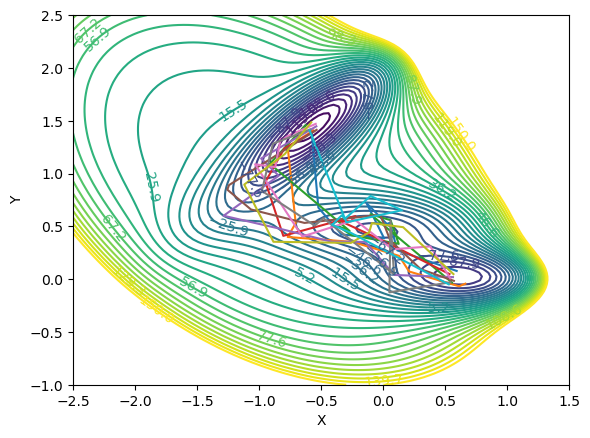

In [17]:
data_path = project_directory + '/data/transition_paths/muller_tps.txt'
file = open(data_path)
csvreader = csv.reader(file)
tp_len = 9

c = 0
tps = []
for row in csvreader:
    if c > 4000:
        break
    arr = np.zeros((len(row), 2))
    for i in range(arr.shape[0]):
        str_list = row[i].strip('[]').split()
        arr[i] = np.array([float(num) for num in str_list])
    arr.astype(float)
    tps.append(arr)
    c+=1
file.close()

arr = np.array(tps).astype(float)
arr = helpers.reshape_ts_np(arr, tp_len)
times = arr[:,-1,0]
data_em = arr[:,:-1]
print(data_em.shape)

visualize(data_em[:10])

(4000, 9, 2)


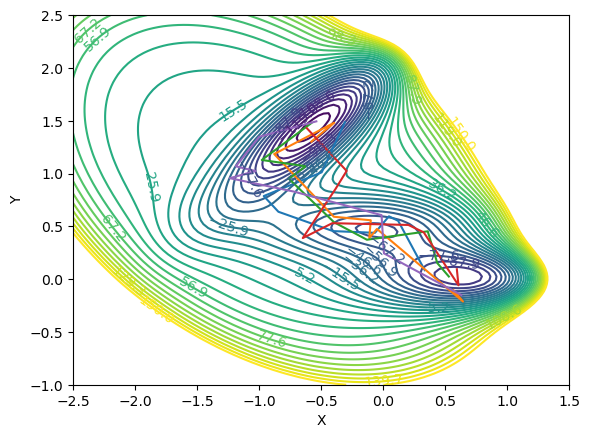

In [18]:
data_path = project_directory + '/data/transition_paths/midpoint_test'
file = open(data_path)
csvreader = csv.reader(file)

c = 0
tps = []
for row in csvreader:
    if c > 4000:
        break
    arr = np.zeros((len(row), 2))
    for i in range(arr.shape[0]):
        str_list = row[i].strip('[]').split()
        arr[i] = np.array([float(num) for num in str_list])
    arr.astype(float)
    tps.append(arr)
    c+=1
file.close()

arr = np.array(tps).astype(float)
data_gen = arr
print(data_gen.shape)

visualize(data_gen[10:15])

(50, 50) (50, 50) (50, 50)


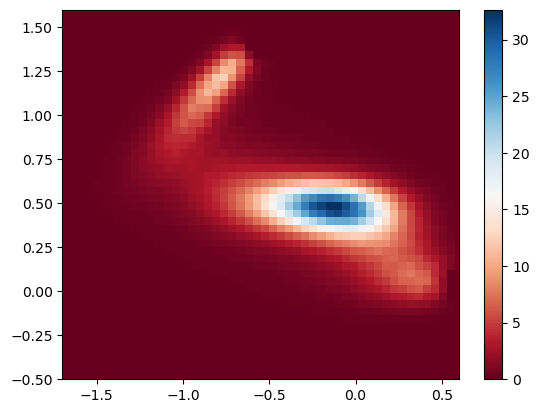

In [19]:
potential = np.zeros_like(interp_vals)
for i in range(potential.shape[0]):
    pts = np.column_stack((x[i], y[i]))
    pot = np.exp(-muller.get_potential(pts) / (10 * np.sqrt(2)))
    potential[i] = pot

pdf_values = interp_vals * (1-interp_vals) * potential
pdf_values = pdf_values

z_min, z_max = 0, pdf_values.max()

fig, ax = plt.subplots()

print(x.shape, y.shape, pdf_values.shape)
c = ax.pcolormesh(x, y, pdf_values, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

(4001, 9, 2)


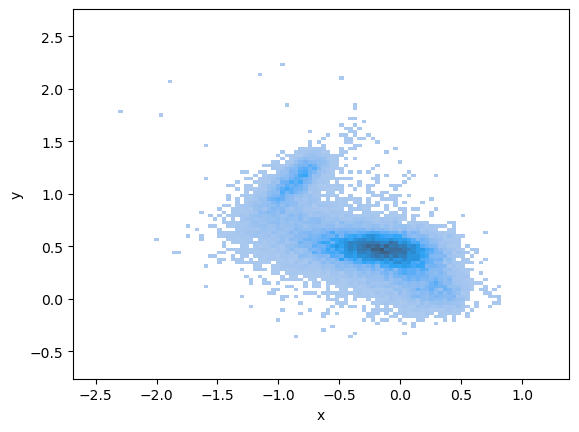

In [20]:
print(data_em.shape)
arr2 = data_em[:,1:-1]
data_tra = arr2.reshape((arr2.shape[0] * arr2.shape[1], arr2.shape[2]))
plot_data = pd.DataFrame(data_tra,columns=['x','y'])
sns.histplot(data=plot_data, x="x", y="y", bins=100, stat="density", binrange=((-2.5,1.2), (-0.6, 2.6)))
# plot_contours(muller)
plt.show()

(4000, 9, 2)


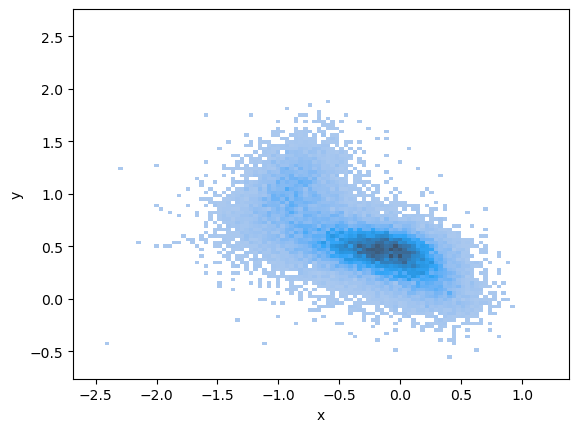

In [21]:
print(data_gen.shape)
arr2 = data_gen[:,1:-1]
data_out = arr2.reshape((arr2.shape[0] * arr2.shape[1], arr2.shape[2]))
plot_data = pd.DataFrame(data_out,columns=['x','y'])
sns.histplot(data=plot_data, x="x", y="y", bins=100, stat="density", binrange=((-2.5,1.2), (-0.6, 2.6)))
# plot_contours(muller)
plt.show()

In [22]:
from scipy.stats import gaussian_kde
from scipy.stats import entropy

# Estimate the probability density functions using KDE
kde1 = gaussian_kde(data_tra.T)
kde2 = gaussian_kde(data_out.T)

points = np.column_stack((x.ravel(), y.ravel()))

# points = np.genfromtxt('/home/ugrad/lft4/DiffusionModelsTP/data/trajectories/mp_trajectory_mala_1_b=10root2_n=50000_steps=100000', delimiter=',')
# points = points[1:500]

print(kde1.pdf(points.T).shape)
print(pdf_values.ravel().shape)

dist_tra = kde1.pdf(points.T)
dist_out = kde2.pdf(points.T)

dist_tra_r = dist_tra / np.mean(dist_tra) / area
dist_out_r = dist_out / np.mean(dist_out) / area
pdf_values_r = pdf_values / np.mean(pdf_values) / area

kl_divergence1 = entropy(dist_tra_r, dist_out_r)
kl_divergence2 = entropy(pdf_values_r.ravel(), dist_tra_r)
kl_divergence3 = entropy(pdf_values_r.ravel(), dist_out_r)

print("KL divergence (training + output):", kl_divergence1)
print("KL divergence (training + true):", kl_divergence2)
print("KL divergence (true + output):", kl_divergence3)

(2500,)
(2500,)
KL divergence (training + output): 0.041694171095432886
KL divergence (training + true): 0.030779299519948414
KL divergence (true + output): 0.11213556809273748


(50, 50) (50, 50) (50, 50)


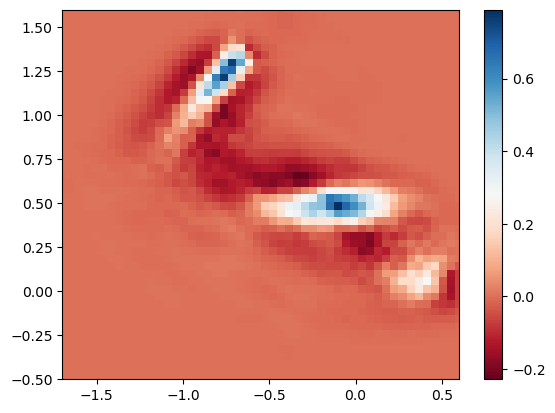

(50, 50) (50, 50) (50, 50)


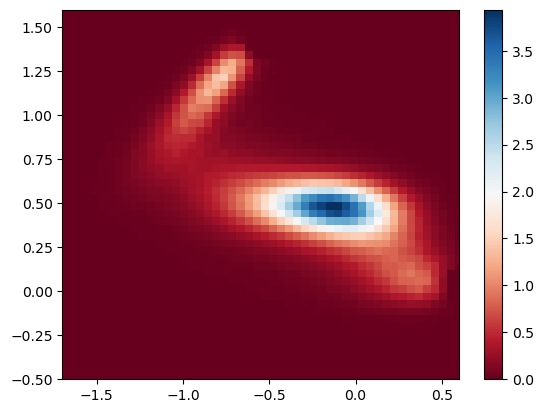

In [23]:
#REAL AND TRAINING

val = pdf_values_r - dist_tra_r.reshape(50, 50)
z_min, z_max = val.min(), val.max()

fig, ax = plt.subplots()

print(x.shape, y.shape, val.shape)
c = ax.pcolormesh(x, y, val, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

val = pdf_values_r
z_min, z_max = val.min(), val.max()

fig, ax = plt.subplots()

print(x.shape, y.shape, val.shape)
c = ax.pcolormesh(x, y, val, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

0.04264670323331886
0.033667523334201886
0.07114592056079413
0.20703933747412007
(50, 50) (50, 50) (50, 50)


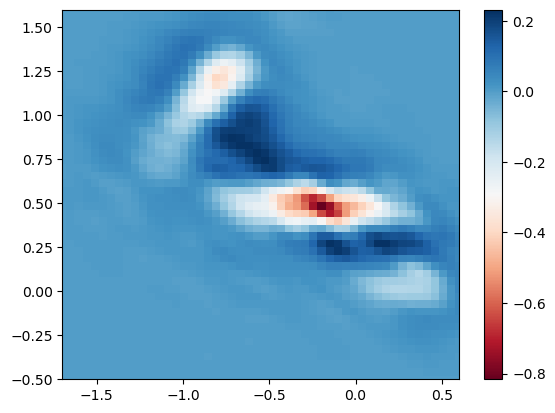

(50, 50) (50, 50) (50, 50)


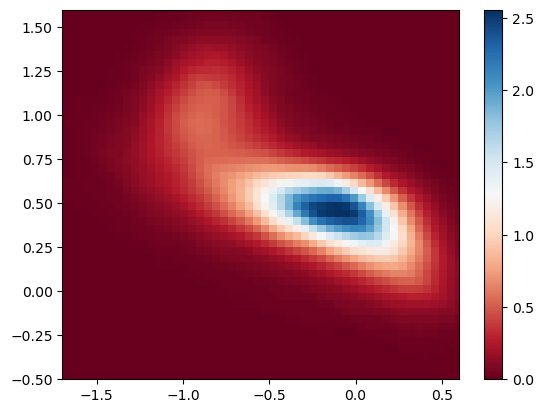

In [24]:
val = dist_out_r.reshape(50, 50) - dist_tra_r.reshape(50, 50)
val2 = pdf_values_r - dist_tra_r.reshape(50, 50)
val3 = pdf_values_r - dist_out_r.reshape(50, 50)
print(np.average(np.abs(val)))
print(np.average(np.abs(val2)))
print(np.average(np.abs(val3)))

print(np.average(np.abs(pdf_values_r)))
z_min, z_max = val.min(), val.max()

fig, ax = plt.subplots()

print(x.shape, y.shape, val.shape)
c = ax.pcolormesh(x, y, val, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

val = dist_out_r.reshape(50, 50)
z_min, z_max = val.min(), val.max()

fig, ax = plt.subplots()

print(x.shape, y.shape, val.shape)
c = ax.pcolormesh(x, y, val, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()